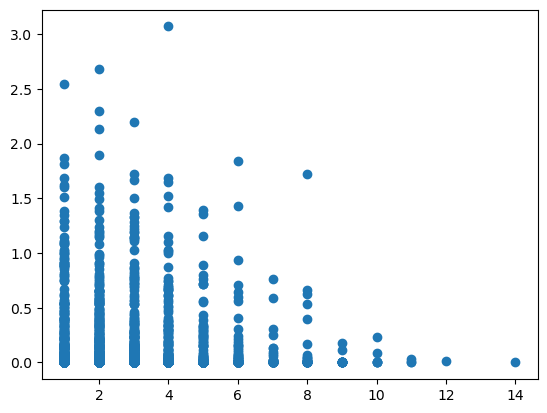

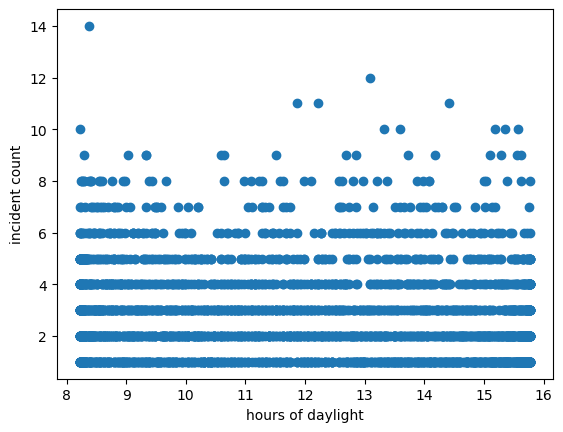

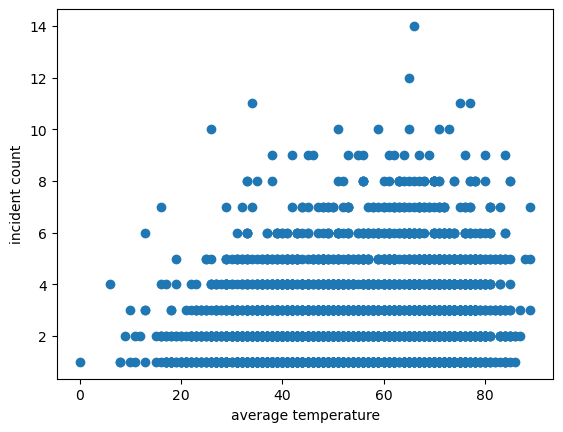

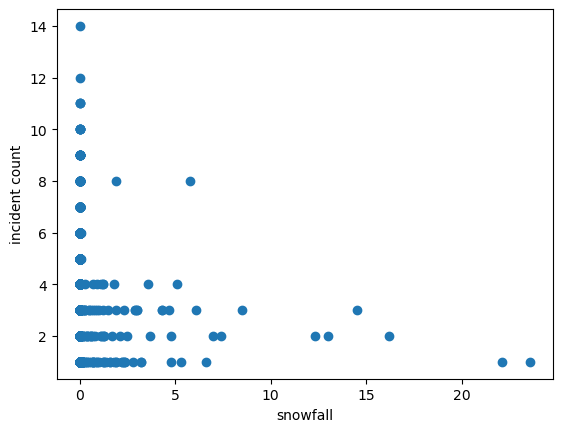

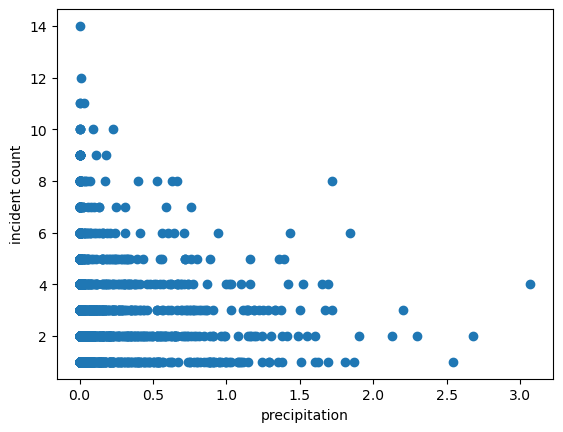

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%run 'ShotsFired_EDA.ipynb'


In [2]:
# data lookin good
shots_daily.head()

,incident_date,district,ballistics_evidence,incident_count,PRCP,SNOW,TAVG,daylight_hours
0,2015-01-01,C11A15,False,2,0.00,0.0,26,12.587640
1,2015-01-02,B3E13,True,2,0.00,0.0,34,12.646087
2,2015-01-03,B2,False,1,0.62,1.4,28,12.704440
3,2015-01-04,B2B2,True,2,0.57,0.0,38,12.762693
4,2015-01-05,C6,False,1,0.00,0.0,40,12.820834


In [3]:
# let's create a X and y

X = shots_daily[['TAVG', 'SNOW', 'PRCP']]
y = shots_daily['incident_count']

print(X.shape)
print(y.shape)


(2806, 3)
(2806,)


In [4]:
# let's split our data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# let's scale our data

# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# ss.fit(X_train)
# X_train = ss.transform(X_train)
# X_test = ss.transform(X_test)

In [5]:
# let's run a linear regression using keras

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

model = keras.Sequential([
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(13, activation='softmax')
])


In [6]:
y_train = tf.one_hot(y_train, depth=13)
y_test = tf.one_hot(y_test, depth=13)

In [7]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [8]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [9]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
)

callback_val_accuracy = keras.callbacks.EarlyStopping(
    monitor="vall_accuracy",
    patience=6,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0000
)

In [10]:
batch_size = 128
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    validation_split=0.1
                    )

Epoch 1/100
15/15 [==============================] - 0s 5ms/step - loss: 7.7840 - accuracy: 0.1817 - val_loss: 2.5969 - val_accuracy: 0.1848 - lr: 0.0100
Epoch 2/100
15/15 [==============================] - 0s 1ms/step - loss: 2.3503 - accuracy: 0.2118 - val_loss: 2.3500 - val_accuracy: 0.1848 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - 0s 1ms/step - loss: 1.9719 - accuracy: 0.2414 - val_loss: 2.2114 - val_accuracy: 0.1943 - lr: 0.0100
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 1.9105 - accuracy: 0.2430 - val_loss: 2.2243 - val_accuracy: 0.2085 - lr: 0.0100
Epoch 5/100
15/15 [==============================] - 0s 1ms/step - loss: 1.9004 - accuracy: 0.2446 - val_loss: 2.1822 - val_accuracy: 0.1848 - lr: 0.0100
Epoch 6/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8926 - accuracy: 0.2398 - val_loss: 2.1683 - val_accuracy: 0.2133 - lr: 0.0100
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss: 1.8

In [11]:
# let's score our model

model.evaluate(X_test, y_test, verbose=2)

22/22 - 0s - loss: 1.6919 - accuracy: 0.3276 - 58ms/epoch - 3ms/step


[1.6919043064117432, 0.3276353180408478]

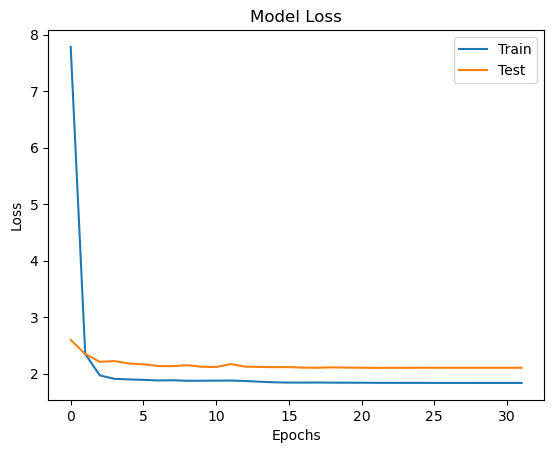

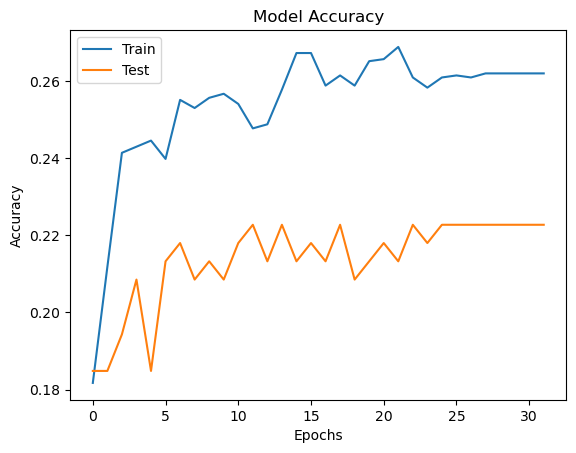

In [12]:
# let's plot our loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()


In [13]:
# idea: we could try  and build models for every district, since different districts may have different trends
# we might be mixing too many trends here and that's why our model is not performing well

In [14]:
# let's plot a confusion matrix

from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = pd.Series(y_pred)
y_pred

y_test = pd.Series(y_test)
y_test

confusion_matrix(y_test, y_pred)

# now let's plot this confusion matrix

import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

22/22 [==============================] - 0s 359us/step


ValueError: Data must be 1-dimensional, got ndarray of shape (702, 13) instead